In [1]:
!pip install torchdiffeq

In [2]:
import torch
print(torch.cuda.is_available())   # True여야 GPU 사용 가능
print(torch.cuda.device_count())   # GPU 개수
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
NVIDIA A100-SXM4-40GB


In [3]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)                  # Python random 고정
    np.random.seed(seed)               # Numpy random 고정
    torch.manual_seed(seed)            # PyTorch CPU 고정
    torch.cuda.manual_seed(seed)       # PyTorch GPU 단일 고정

    # 연산 재현성 보장 (속도는 약간 손해봄)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,)),  # [-1,1] 범위
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [-1,1] 범위
    #transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset = Subset(train_dataset, range(50000))
train_loader = DataLoader(subset, batch_size=256, shuffle=True)

val_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_subset = Subset(val_dataset, range(5000))
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)

dim = 64

# --------------------------------------
# 2. 벡터장 모델
# --------------------------------------
# CNN 기반 Vector Field
class ConvVectorField(nn.Module):
    def __init__(self, hidden_dim=64):  # ← 32 → 64 권장
        super().__init__()
        act = nn.SiLU

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3+1, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            act(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            act(),
        )
        self.down1 = nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=2, padding=1)  # 32→16

        self.enc2 = nn.Sequential(
            nn.GroupNorm(16, hidden_dim*2),
            act(),
            nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1),
            nn.GroupNorm(16, hidden_dim*2),
            act(),
        )
        self.down2 = nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, stride=2, padding=1)  # 16→8

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.GroupNorm(32, hidden_dim*4),
            act(),
            nn.Conv2d(hidden_dim*4, hidden_dim*4, 3, padding=1),
            nn.GroupNorm(32, hidden_dim*4),
            act(),
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, stride=2, padding=1)  # 8→16
        self.dec1 = nn.Sequential(
            nn.GroupNorm(16, hidden_dim*2 + hidden_dim*2),  # concat(enc2)
            act(),
            nn.Conv2d(hidden_dim*2 + hidden_dim*2, hidden_dim*2, 3, padding=1),
            nn.GroupNorm(16, hidden_dim*2),
            act(),
        )

        self.up2 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=2, padding=1)  # 16→32
        self.dec2 = nn.Sequential(
            nn.GroupNorm(8, hidden_dim + hidden_dim),  # concat(enc1)
            act(),
            nn.Conv2d(hidden_dim + hidden_dim, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            act(),
        )

        self.conv_out = nn.Conv2d(hidden_dim, 3, 3, padding=1)

    def forward(self, x, t):
        # x: (B,3,32,32), t: (B,1,32,32)  ← 기존과 동일 가정
        xt = torch.cat([x, t], dim=1)  # (B,4,32,32)

        # Encoder
        e1 = self.enc1(xt)             # 32x32, C=h
        h  = self.down1(e1)            # 16x16, C=2h
        e2 = self.enc2(h)              # 16x16, C=2h
        h  = self.down2(e2)            # 8x8,   C=4h

        # Bottleneck
        h = self.bottleneck(h)         # 8x8,   C=4h

        # Decoder + skips
        h = self.up1(h)                # 16x16, C=2h
        h = torch.cat([h, e2], dim=1)  # 16x16, C=4h
        h = self.dec1(h)               # 16x16, C=2h

        h = self.up2(h)                # 32x32, C=h
        h = torch.cat([h, e1], dim=1)  # 32x32, C=2h
        h = self.dec2(h)               # 32x32, C=h

        out = self.conv_out(h)         # (B,3,32,32)
        return out


# --------------------------------------
# 3. Flow Matching Loss
# --------------------------------------
def flow_matching_loss(model, x0, x1, t):
    # t: (B, C, H, W)  — 채널/공간으로 broadcast된 t
    t_scalar = t[:, :1, :1, :1]  # (B,1,1,1)

    xt = (1 - t) * x0 + t * x1
    ut_target = x1 - x0

    # 모델 입력용 t (B,1,H,W)
    input_t = t_scalar.expand(-1, 1, x1.shape[2], x1.shape[3])
    ut_pred = model(xt, input_t)

    # 시간 가중치
    w = (t_scalar * (1 - t_scalar) + 1e-3)
    return (w * (ut_pred - ut_target).pow(2)).mean()

# --------------------------------------
# 4. 학습 루프
# --------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvVectorField(dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

epochs = 100
losses = []
val_losses = []
accumulation_steps = 4

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        x1 = images.to(device)                    # target = CIFAR image
        x0 = torch.randn_like(x1).to(device)      # source = Gaussian
        t_scalar = Beta(0.5, 0.5).sample((x1.size(0), 1, 1, 1)).to(device)
        t = t_scalar.expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])

        loss = flow_matching_loss(model, x0, x1, t)

        loss = loss / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    losses.append(loss.item())

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            x1 = images.to(device)
            x0 = torch.randn_like(x1).to(device)
            t_scalar = Beta(0.5, 0.5).sample((x1.size(0), 1, 1, 1)).to(device)
            t = t_scalar.expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])
            val_loss = flow_matching_loss(model, x0, x1, t)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # 🔹 Best checkpoint 저장 (val_loss 기준)
    if epoch == 0:
        best_val_loss = avg_val_loss

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        ckpt_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss.item(),
        "val_loss": avg_val_loss,
        }, ckpt_path)
        print(f"✅ Best model updated at epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")

# Loss 곡선 그리기
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()


Epoch 1, Loss: 0.0116
Epoch 2, Loss: 0.0092
✅ Best model updated at epoch 2 | Val Loss: 0.0377
Epoch 3, Loss: 0.0082
✅ Best model updated at epoch 3 | Val Loss: 0.0333
Epoch 4, Loss: 0.0073
✅ Best model updated at epoch 4 | Val Loss: 0.0319
Epoch 5, Loss: 0.0070
✅ Best model updated at epoch 5 | Val Loss: 0.0303
Epoch 6, Loss: 0.0080
✅ Best model updated at epoch 6 | Val Loss: 0.0292
Epoch 7, Loss: 0.0068
✅ Best model updated at epoch 7 | Val Loss: 0.0281
Epoch 8, Loss: 0.0062
✅ Best model updated at epoch 8 | Val Loss: 0.0280
Epoch 9, Loss: 0.0058
✅ Best model updated at epoch 9 | Val Loss: 0.0271
Epoch 10, Loss: 0.0054
✅ Best model updated at epoch 10 | Val Loss: 0.0262
Epoch 11, Loss: 0.0074
Epoch 12, Loss: 0.0056
✅ Best model updated at epoch 12 | Val Loss: 0.0257
Epoch 13, Loss: 0.0064
✅ Best model updated at epoch 13 | Val Loss: 0.0253
Epoch 14, Loss: 0.0068
✅ Best model updated at epoch 14 | Val Loss: 0.0251
Epoch 15, Loss: 0.0065
Epoch 16, Loss: 0.0058
Epoch 17, Loss: 0.0064
✅ 

KeyboardInterrupt: 

In [ ]:
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    total_loss = 0
    count = 0
    for images, _ in test_loader:
        x1 = images.to(device)
        x0 = torch.randn_like(x1).to(device)
        t_scalar = Beta(0.5, 0.5).sample((x1.size(0), 1, 1, 1)).to(device)
        t = t_scalar.expand(-1, x1.shape[1], x1.shape[2], x1.shape[3])

        loss = flow_matching_loss(model, x0, x1, t)
        total_loss += loss.item() * len(x1)
        count += len(x1)
    print("Test Loss:", total_loss / count)

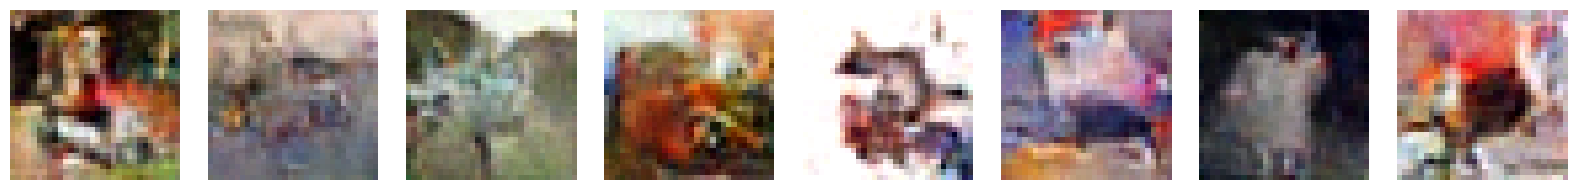

In [5]:
from torchdiffeq import odeint

def sample_images(model, n_samples=8, steps=20, device="cuda"):
    model.eval()
    with torch.no_grad():
        x0 = torch.randn(n_samples, 3, 32, 32, device=device)  # t=0 초기 노이즈

        def ode_func(t, x_flat):
            # x: (B,3,32,32)
            x = x_flat.view(n_samples, 3, 32, 32)

            # ODE가 주는 스칼라 시간 t 사용 → (B,1,H,W)로 브로드캐스트
            t_img = t.reshape(1,1,1,1).to(device).expand(n_samples, 1, 32, 32)

            # 모델은 v_theta(x,t) = dx/dt 반환
            dx = model(x, t_img)        # (B,3,32,32)
            return dx.view(-1)          # flatten

        ts = torch.linspace(0., 1., steps, device=device)
        # 순방향(0→1): x0 ~ N(0,I) → 데이터로 이동
        xT = odeint(ode_func, x0.view(-1), ts, method="rk4")[-1]
        xT = xT.view(n_samples, 3, 32, 32).clamp_(-1, 1)  # [-1,1] 범위로 클램프(시각화용)
        return xT.detach().cpu()

model.to(device)
samples = sample_images(model, n_samples=8, steps=40, device=device)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    img = samples[i].permute(1,2,0).numpy()
    img = (img + 1) / 2.0               # [-1,1] → [0,1]
    img = img.clip(0,1)
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Model load**

In [ ]:
ckpt = torch.load("./checkpoints/checkpoint_epoch_100.pth", map_location=device)

model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch = ckpt["epoch"]
print(f"🔄 Resumed from epoch {start_epoch}, last loss = {ckpt['loss']:.4f}")